In [1]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import ibsen
from ibsen.orbit import Orbit

DAY = 86400.
AU = 1.5e13

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name, n=1003)
from ibsen.winds import Winds
winds = Winds(orbit=orb, sys_name = sys_name, alpha=-10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.02, np_disk=3, rad_prof='pl', r_trunk=None,
             height_exp=0.25)

Now it's time for the intrabinary shock (ibs) from class IBS. I use the model from Canto, Raga, and Wilkin

https://ui.adsabs.harvard.edu/abs/1996ApJ...469..729C/abstract

in which (if coordinates are in units of birary separation) the shock shape depends only on one parameter $\beta$, the relation between the pulsar and the optical star _spherical_ winds momenta. 

![ibs](../../Pictures/IBS.jpg)


To initialize the IBS, you need ``beta`` (float) and ``s_max`` which defines where the shock ends. ``s_max`` should be either a float ($\leq 5$, then it is treated as maximum arclength in dimensionless units) or a string ''bow'' (then only such part of the IBS left that $\theta \leq 90^\circ$), or a string ''incl'' (then only such part of the IBS left that the angle between the tangent and the direction to the pulsar is $\leq 90^\circ + 10^\circ$).

You can either just pass $\beta=...$ as an argument and obtain the shock coordinates (x, y, r, ...) or you can pass winds:Winds class as an argument together with ``t_forbeta`` to calculate the effective $\beta_\mathrm{eff}$ at time $t_\mathrm{for~beta}$ after periastron passage. You can also rotate the shock or recalculate its properties to the moment ``t_forbeta``. Upon initializing, the class obtains the values x, y, s (arclength from apex to the given point), r, theta, r1, theta1, tangent (the angle between the tangent to a given point and the x-axis), thetainf (the max angle theta), and x_apex (the distance from the pulsar to the IBS apex).

One of the properties of an ibs is the bulk motion of matter along the shock. From ibs:IBS you can retrieve the $\Gamma(s)_\mathrm{bulk}$ --- well, currently it is fixed to a linear growth with the arclength $s$:
\begin{equation}
    \Gamma(s) = 1 + (\Gamma_\mathrm{max}-1)\frac{s}{s_\mathrm{max~g}}
\end{equation}

and Doppler-factor $\delta(s)$. For this, you need to provide the parameters of this linear function: ``gamma_max`` (default = None) and ``s_max_g`` (default = 4).

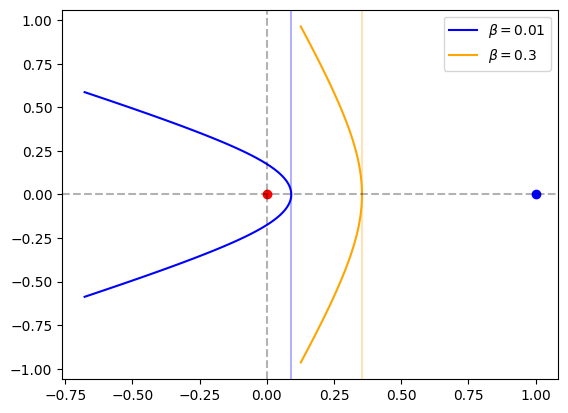

In [2]:
from ibsen.ibs import IBS
# Two very simple dimensonless IBS with given betas

beta1 = 0.01
ibs1 = IBS(beta=beta1, n=51, s_max = 1, one_horn=False) 
plt.plot(ibs1.x, ibs1.y, color='b', label = rf'$\beta = {beta1}$')
plt.axvline(x = ibs1.x_apex, color='b', alpha = 0.3)

beta2 = 0.3
ibs2 = IBS(beta=beta2, n=51, s_max = 1, one_horn=False) 
plt.plot(ibs2.x, ibs2.y, color='orange', label = rf'$\beta = {beta2}$')
plt.axvline(x = ibs2.x_apex, color='orange', alpha = 0.3)


plt.scatter(0, 0, color='r') # pulsar is in (0, 0)
plt.scatter(1, 0, color='b') # star is in (1, 0)
plt.axhline(y=0, color='k', ls='--', alpha = 0.3)
plt.axvline(x=0, color='k', ls='--', alpha = 0.3)
plt.legend()

(-57819055616601.16, 57819055616601.16)

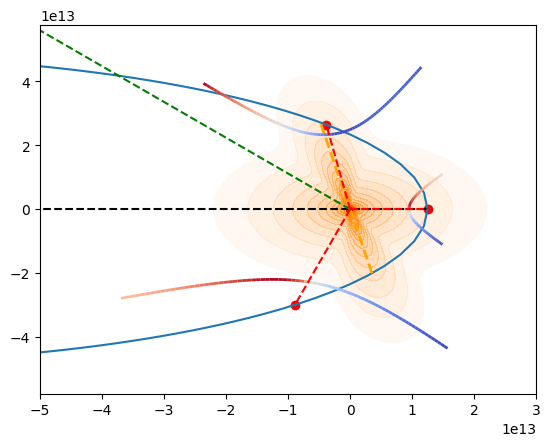

In [4]:
# now let's defnie the IBS with the kinematics of the bulk motion and draw
# several IBSs in several times with color corresponding to the Doppler factor

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, Normalize

########## some helper function for drawing, whatev ############################ 
####################################################################################
####################################################################################
def plot_with_gradient(fig, ax, xdata, ydata, some_param, colorbar=False, lw=2,
                       ls='-', colorbar_label='grad', minimum=None, maximum=None):
    """
    to draw the plot (xdata, ydata) on the axis ax with color along the curve
    marking some_param. The color changes from blue to red as some_param increases.
    You may provide your own min and max values for some_param:
    minimum and maximum, then the color will be scaled according to them.
    """
    # Prepare line segments
    points = np.array([xdata, ydata]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Normalize some_p values to the range [0, 1] for colormap
    vmin_here = minimum if minimum is not None else np.min(some_param)
    vmax_here = maximum if maximum is not None else np.max(some_param)
    
    norm = Normalize(vmin=vmin_here, vmax=vmax_here)
    
    # Create the LineCollection with colormap
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(some_param[:-1])  # color per segment; same length as segments
    lc.set_linewidth(lw)
    
    # Plot

    line = ax.add_collection(lc)
    
    if colorbar:
        fig.colorbar(line, ax=ax, label=colorbar_label)  # optional colorbar
        
    ax.set_xlim(xdata.min(), xdata.max())
    ax.set_ylim(ydata.min(), ydata.max())
####################################################################################
####################################################################################
####################################################################################


#####################################################################################
###### -------------------- drawing orbits and winds ------------------------ #######

fig, ax = plt.subplots()
winds.peek(ax=ax, plot_rs=False, showtime=(-100*DAY, 100*DAY))
#######################################################################################
#######################################################################################
##### For t = 25 days, 0, and 20 days, draw an IBS calculated from the winds initialized
##### before. Draw it with color corresponding to the doppler factor delta.

for t in (-25*DAY, 0*DAY, 20*DAY):
    ibs = IBS(
              beta=None,        # since we also pass winds = ..., we don't need explicit beta
              gamma_max=3.,     # max bulk motion gamma
              s_max=1.,         # where to cut IBS. s_max = 1 means 'cut it where the arclength
                                # along the shock is equal to the 1 orbital separation at a given time'
                                # can also be strings ``bow`` or ``incl``.
        
              s_max_g=4,        # a parameter of a linear function Gamma(s) 
              n=41,             # number of points in ONE horn of IBS to initialize
              one_horn=False,   # whether we want one (upper, theta>0) horn of the IBS
                                # or both horns. If False, then 2 horns will be initialized,
                                # each with n = 41 points.
        
              winds = winds,    # previously initialized class winds:Winds to calculate beta_eff
              t_to_calculate_beta_eff=t  # when to calculate beta_eff
              )
    ibs_real = ibs.rescale_to_position() # rotates the IBS properly and rescales all dimentions to the real ones
    plot_with_gradient(fig=fig, ax=ax,
                       xdata=ibs_real.x, 
                       ydata=ibs_real.y, 
                       some_param=ibs_real.real_dopl # use ibs_real.real_dopl if ibs_real is already an IBS obtained by
                                                     # the ibs.rescale_to_position() method 
                      )
    ax.scatter(orb.x(t), orb.y(t), color='r')
    ax.plot([0, orb.x(t)], [0, orb.y(t)], color='r', ls='--')
# if to_show=='whole':                                                      
#     ax.set_xlim(-orb.a*2, orb.a*2)                                           
#     ax.set_ylim(-orb.b*2, orb.b*2)                                           
                                                                          
# if to_show == 'near_per':                                                 
ax.set_xlim(-0.5e14, 0.3e14)                                             
ax.set_ylim(-orb.b*1.2, orb.b*1.2)